In [1]:
import csv
import os
import re
import tensorflow as tf

from object_detection import evaluator
from object_detection.core import standard_fields
from object_detection.metrics import tf_example_parser
from object_detection.utils import config_util
from object_detection.utils import label_map_util

import numpy as np
# flags = tf.app.flags
# tf.logging.set_verbosity(tf.logging.INFO)

# flags.DEFINE_string('eval_dir', None, 'Directory to write eval summaries to.')
# flags.DEFINE_string('eval_config_path', None,
#                     'Path to an eval_pb2.EvalConfig config file.')
# flags.DEFINE_string('input_config_path', None,
#                     'Path to an eval_pb2.InputConfig config file.')

# FLAGS = flags.FLAGS

In [2]:
def _generate_filenames(filenames):
  result = []
  for filename in filenames:
    result += _generate_sharded_filenames(filename)
  return result

In [3]:
def _generate_sharded_filenames(filename):
  m = re.search(r'@(\d{1,})', filename)
  if m:
    num_shards = int(m.group(1))
    return [
        re.sub(r'@(\d{1,})', '-%.5d-of-%.5d' % (i, num_shards), filename)
        for i in range(num_shards)
    ]
  else:
    return [filename]

In [4]:
  # new format, train_out_547_1GPU1batch_lrPet, per 2 
  required_flags = ['input_config_path', 'eval_config_path', 'eval_dir']
#   for flag_name in required_flags:
#     if not getattr(FLAGS, flag_name):
#       raise ValueError('Flag --{} is required'.format(flag_name))

  configs = config_util.get_configs_from_multiple_files(
      eval_input_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_input_config.pbtxt',
      eval_config_path='/root/oid_bbox_trainable_label_map_add2_validation_eval_metrics_train_out_547_1GPU1batch_lrPet_frozen_697960_ImageID_per2_eval_547_annotation_v4/validation_eval_config.pbtxt')

  eval_config = configs['eval_config']
  input_config = configs['eval_input_config']

In [5]:
  if input_config.WhichOneof('input_reader') == 'tf_record_input_reader':
    input_paths = input_config.tf_record_input_reader.input_path

    label_map = label_map_util.load_labelmap(input_config.label_map_path)
    max_num_classes = max([item.id for item in label_map.item])
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes)

    object_detection_evaluators = evaluator.get_evaluators(
        eval_config, categories)
    # Support a single evaluator
    object_detection_evaluator = object_detection_evaluators[0]

    skipped_images = 0
    processed_images = 0

In [6]:
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
#         print(decoded_dict)
        if True:
#             decoded_dict['detection_classes'][0] = 15
            if decoded_dict:
              object_detection_evaluator.add_single_ground_truth_image_info(
                  decoded_dict[standard_fields.DetectionResultFields.key],
                  decoded_dict)
              object_detection_evaluator.add_single_detected_image_info(
                  decoded_dict[standard_fields.DetectionResultFields.key],
                  decoded_dict)
            else:
              skipped_images += 1
              tf.logging.info('Skipped images: {0}'.format(skipped_images))
#             break
          
        else:
            continue
        if processed_images == 10:
          break
print(processed_images)



INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_validation_ImageID_per2_eval_547_annotation_v4_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 0 images...
895


In [7]:
object_detection_evaluator

In [10]:
    infer_dict = {}
    for input_path in _generate_filenames(input_paths):
      tf.logging.info('Processing file: {0}'.format(input_path))

      record_iterator = tf.python_io.tf_record_iterator(path=input_path)
      data_parser = tf_example_parser.TfExampleDetectionAndGTParser()

      for string_record in record_iterator:
        tf.logging.log_every_n(tf.logging.INFO, 'Processed %d images...', 1000,
                               processed_images)
        processed_images += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        decoded_dict = data_parser.parse(example)
#         print(decoded_dict)
        if True:
#             decoded_dict['detection_classes'][0] = 15
            if decoded_dict:
                infer_dict[decoded_dict[standard_fields.DetectionResultFields.key]]= \
                    decoded_dict
#               object_detection_evaluator.add_single_ground_truth_image_info(
#                   decoded_dict[standard_fields.DetectionResultFields.key],
#                   decoded_dict)
#               object_detection_evaluator.add_single_detected_image_info(
#                   decoded_dict[standard_fields.DetectionResultFields.key],
#                   decoded_dict)
            else:
              skipped_images += 1
              tf.logging.info('Skipped images: {0}'.format(skipped_images))
#             break
          
        else:
            continue
        if processed_images == 10:
          break
print(processed_images)




INFO:tensorflow:Processing file: /root/oid_bbox_trainable_label_map_add2_train_out_547_1GPU1batch_lrPet_frozen_697960_validation_ImageID_per2_eval_547_annotation_v4_detections.tfrecord-00000-of-00001
INFO:tensorflow:Processed 895 images...
1790


In [209]:
gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

In [210]:
det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

In [211]:
tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

In [212]:
fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

In [213]:
threshold = 0.2

In [214]:
# 239: ok , 172: ok
cnt = 0
for image, decoded_dict in infer_dict.items():
    if 172 in decoded_dict['groundtruth_classes']:
        if cnt == 4:
            break
        cnt += 1
    else:
        continue
    
    gt_classes_set = set()
    for groundtruth_classes in decoded_dict['groundtruth_classes']:
        gt_classes_set.add(groundtruth_classes)
    for groundtruth_classes in gt_classes_set:
        gt_num_per_class[groundtruth_classes] += 1
    print(gt_classes_set)
    print(decoded_dict['groundtruth_classes'])
    print(decoded_dict['detection_classes'][0:4])
    print(decoded_dict['detection_scores'][0:4])

#     break

set([131, 9, 172, 336, 18, 157])
[131 157  18  18   9 336 336 172]
[ 20 131  91 131]
[0.65566301 0.57859415 0.57595021 0.55533719]
set([155, 172, 239])
[155 239 172 172]
[382 172 172 172]
[0.59592563 0.48184073 0.26300594 0.2539587 ]
set([472, 210, 172, 122, 174])
[210 122 174 472 172]
[472 155 122 472]
[0.94710582 0.49336645 0.44023651 0.25035304]
set([472, 498, 155, 172])
[155 498 472 172 172 172]
[506 155 523 172]
[0.44394732 0.38562202 0.37128848 0.2216956 ]


In [215]:
cnt = 0
for image, decoded_dict in infer_dict.items():
    if 172 in decoded_dict['groundtruth_classes']:
        if cnt == 4:
            break
        cnt += 1
    else:
        continue
    index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
    detection_classes_set = set()
    for detection_classes in decoded_dict['detection_classes'][index_threshold]:
        detection_classes_set.add(detection_classes)
    print(detection_classes_set)
    for detection_classes in detection_classes_set:
        if detection_classes in decoded_dict['groundtruth_classes']:
            tp_num_per_class[detection_classes] += 1
        else:
            fp_num_per_class[detection_classes] += 1
        det_num_per_class[detection_classes] += 1
#     break


set([131, 9, 42, 75, 77, 336, 19, 20, 23, 91, 157])
set([498, 172, 382])
set([472, 122, 155, 210])
set([523, 472, 506, 155, 172])


In [216]:
precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

In [217]:
for idx, det in enumerate(det_num_per_class):
    if det == 0:
        precision_per_class[idx] = np.nan
    else:
        precision_per_class[idx] = tp_num_per_class[idx] / det
    

In [218]:
precision_per_class

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, 1. , nan, nan, nan,
       nan, nan, nan, nan, nan, nan, 0. , 0. , nan, nan, 0. , nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 0. , nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0. , nan, 0. ,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       0. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 1. , nan, nan, nan, nan, nan, nan, nan,
       nan, 1. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.5,
       nan, 1. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 1. , nan, nan, nan, nan, nan, nan, nan, na

In [219]:
np.nanmean(precision_per_class)

0.425

In [220]:
for idx, det in enumerate(gt_num_per_class):
    if det == 0:
        recall_per_class[idx] = np.nan
    else:
        recall_per_class[idx] = tp_num_per_class[idx] / det
    

In [221]:
recall_per_class

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, 1. , nan, nan, nan,
       nan, nan, nan, nan, nan, 0. , nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, 1. , nan, nan, nan, nan, nan, nan, nan,
       nan, 1. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.5,
       nan, 1. , nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, 0.5, nan, 0. , nan, nan, nan, nan, nan, na

In [223]:
recall_per_class[172]

0.5

In [224]:
precision_per_class[172]

1.0

In [85]:
# fscore_per_class = 2.0/(precision_per_class + recall_per_class)*precision_per_class*recall_per_class

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [229]:
## th 0 - 1.0
# threshold = 0.2
thresholds = np.linspace(0.0, 1.0, num=11)
precision_per_th = []
recall_per_th = []
fscore_per_th = []

for idx, threshold in enumerate(thresholds):

    gt_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    det_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    tp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    fp_num_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0


    for image, decoded_dict in infer_dict.items():
        gt_classes_set = set()
        for groundtruth_classes in decoded_dict['groundtruth_classes']:
            gt_classes_set.add(groundtruth_classes)
        for groundtruth_classes in gt_classes_set:
            gt_num_per_class[groundtruth_classes] += 1


    for image, decoded_dict in infer_dict.items():
        index_threshold = np.where(decoded_dict['detection_scores'] >= threshold)
        detection_classes_set = set()
        for detection_classes in decoded_dict['detection_classes'][index_threshold]:
            detection_classes_set.add(detection_classes)
        for detection_classes in detection_classes_set:
            if detection_classes in decoded_dict['groundtruth_classes']:
                tp_num_per_class[detection_classes] += 1
            else:
                fp_num_per_class[detection_classes] += 1
            det_num_per_class[detection_classes] += 1


    precision_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    recall_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0

    for idx, det in enumerate(det_num_per_class):
        if det == 0:
            precision_per_class[idx] = np.nan
        else:
            precision_per_class[idx] = tp_num_per_class[idx] / det

    for idx, det in enumerate(gt_num_per_class):
        if det == 0:
            recall_per_class[idx] = np.nan
        else:
            recall_per_class[idx] = tp_num_per_class[idx] / det

    fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
    for idx, fscore in enumerate(fscore_per_class):
        if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
            fscore_per_class[idx] = 0
        else :
            fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]

    precision_per_th.append(np.nanmean(precision_per_class))
    recall_per_th.append(np.nanmean(recall_per_class))
    fscore_per_th.append(np.nanmean(fscore_per_class))
    


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


In [230]:
precision_per_th

[0.09320097499227827,
 0.4901271293138463,
 0.605775302734768,
 0.6621213631450162,
 0.7137967764988978,
 0.7603057631477119,
 0.805703948245965,
 0.849624802527646,
 0.8846332404828227,
 0.9237338044758538,
 nan]

In [234]:
precision_per_th[-1] = 1

In [231]:
recall_per_th

[0.9806387322109427,
 0.8629124827528531,
 0.800624666272685,
 0.7392600657975228,
 0.6776419669166625,
 0.6244671885982102,
 0.5645780523343275,
 0.5035164261798424,
 0.42992360419991393,
 0.3448938875734456,
 0.0]

In [232]:
fscore_per_th

[0.16296523696772658,
 0.5932931182712152,
 0.6572282243717381,
 0.6694269149063545,
 0.675251493579807,
 0.6827762181396972,
 0.6807691414107645,
 0.6893280511847583,
 0.7087420611655524,
 0.7368226786954702,
 nan]

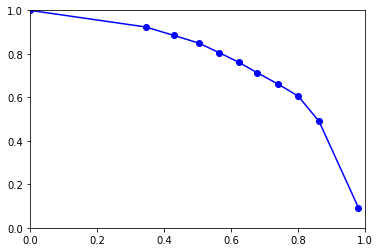

In [240]:
y=precision_per_th
x=recall_per_th
plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
# IMAGE_SIZE = (12, 8)
# plt.figure(figsize=IMAGE_SIZE)

# plt.figure(figsize=IMAGE_SIZE, dpi=80)

plt.plot(x, y, '-ob');
plt.savefig('/root/PR_per2.png', transparent=False, dpi = 300)



In [241]:
from sklearn.metrics import roc_curve, auc

auc(x,y)

0.7588234266091839

0.7597256711266973


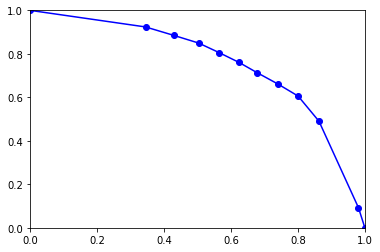

In [243]:
from sklearn.metrics import roc_curve, auc
xx = x[:]
yy = y[:]
xx.insert(0,1)
yy.insert(0,0)
print(auc(xx,yy))

plt.xlim(0, 1.0);
plt.ylim(0, 1.0);
plt.plot(xx, yy, '-ob');
plt.savefig('/root/PR_per2_2.png', transparent=False, dpi = 300)

# simcloud -c mr2 job scp -r   $DID:~/PR_per2_2.png ~/openimage



In [244]:
print(x)
print(y)
print(fscore_per_th)

[0.9806387322109427, 0.8629124827528531, 0.800624666272685, 0.7392600657975228, 0.6776419669166625, 0.6244671885982102, 0.5645780523343275, 0.5035164261798424, 0.42992360419991393, 0.3448938875734456, 0.0]
[0.09320097499227827, 0.4901271293138463, 0.605775302734768, 0.6621213631450162, 0.7137967764988978, 0.7603057631477119, 0.805703948245965, 0.849624802527646, 0.8846332404828227, 0.9237338044758538, 1]
[0.16296523696772658, 0.5932931182712152, 0.6572282243717381, 0.6694269149063545, 0.675251493579807, 0.6827762181396972, 0.6807691414107645, 0.6893280511847583, 0.7087420611655524, 0.7368226786954702, nan]


In [79]:
np.nanmean(recall_per_class)

0.5104762846325388

In [35]:
np.where(decoded_dict['detection_scores'] >= 0.4)

(array([0, 1]),)

In [117]:
fscore_per_class = np.zeros(object_detection_evaluator._evaluation.num_class+1 )#ignore index = 0
for idx, fscore in enumerate(fscore_per_class):
    if precision_per_class[idx] == 0 and recall_per_class[idx] == 0:
        fscore_per_class[idx] = 0
    elif :
        fscore_per_class[idx] = 2.0/(precision_per_class[idx] + recall_per_class[idx])*precision_per_class[idx]*recall_per_class[idx]


In [33]:
decoded_dict['detection_scores']

array([0.94740069, 0.44336295, 0.11177488, 0.06715006, 0.06292228,
       0.05310643, 0.05143602, 0.04563433, 0.04244808, 0.02040432,
       0.01258927, 0.01234233, 0.0116198 , 0.01158036, 0.0109454 ,
       0.00998489, 0.00996538, 0.00983375, 0.00902759, 0.00861758,
       0.00738818, 0.00711295, 0.00637355, 0.00590948, 0.00588783,
       0.00550458, 0.005255  , 0.00507754, 0.0050324 , 0.00432808,
       0.00426304, 0.00404781, 0.00394155, 0.00388545, 0.00371365,
       0.00366338, 0.00364014, 0.00315609, 0.00312454, 0.00308078,
       0.00305687, 0.00298963, 0.0029583 , 0.00283483, 0.00281596,
       0.00279417, 0.0027192 , 0.00270064, 0.00260162, 0.00258033,
       0.00257703, 0.00248641, 0.00242757, 0.00238891, 0.00231176,
       0.00225751, 0.00221358, 0.00217928, 0.00206117, 0.00193725,
       0.0019113 , 0.00184843, 0.00184705, 0.00183507, 0.00182395,
       0.00181492, 0.0017796 , 0.00175285, 0.00174065, 0.00172844,
       0.00164231, 0.00160236, 0.00159087, 0.00155847, 0.00141

In [37]:
decoded_dict['detection_classes'][index_threshold]

array([282])

In [38]:
decoded_dict

{'detection_boxes': array([[1.00309551e-01, 9.61471349e-02, 1.00000000e+00, 6.00033998e-01],
        [5.99940233e-02, 2.31923044e-01, 6.07892871e-01, 6.34490252e-01],
        [8.99344385e-02, 9.64855999e-02, 1.00000000e+00, 5.99817455e-01],
        [7.54189044e-02, 2.43108958e-01, 1.00000000e+00, 7.92661130e-01],
        [9.65380892e-02, 6.64914697e-02, 9.83669758e-01, 6.20056272e-01],
        [6.47381619e-02, 9.28268477e-04, 8.53293657e-01, 4.68848377e-01],
        [9.32818130e-02, 5.82458004e-02, 5.60767591e-01, 5.43001115e-01],
        [6.26673400e-02, 1.62722282e-02, 9.52440321e-01, 5.06614029e-01],
        [4.83484149e-01, 6.43990159e-01, 7.09498584e-01, 9.38515425e-01],
        [4.83773857e-01, 6.68718457e-01, 6.93948209e-01, 9.30284262e-01],
        [1.42060757e-01, 0.00000000e+00, 1.00000000e+00, 6.63463950e-01],
        [1.24948507e-03, 2.64343005e-02, 1.88093930e-01, 4.33495194e-01],
        [2.32349142e-01, 3.53246816e-02, 9.99332488e-01, 6.56445026e-01],
        [1.75343454

[u'Kitchen utensil', u'Tableware', u'Fork']


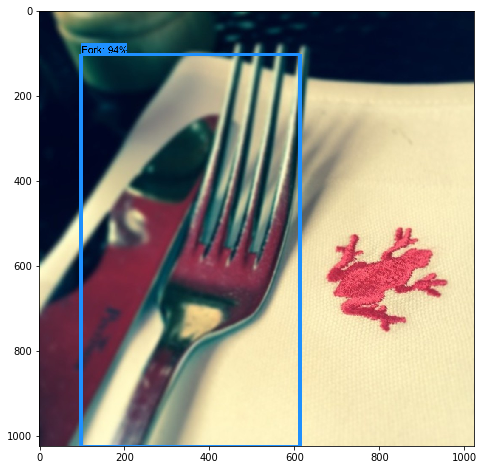

In [41]:
import cv2
from utils import visualization_utils as vis_util
from matplotlib import pyplot as plt
%matplotlib inline

PATH_TO_LABELS = os.path.join('/root/models/research/object_detection/data', 'oid_bbox_trainable_label_map_add2.pbtxt')
NUM_CLASSES = 547
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#.jpg # v4 model
image_path='/root/raw_images_validation/'+decoded_dict[standard_fields.DetectionResultFields.key]+'.jpg'

# image = Image.open(image_path)
# image_np = load_image_into_numpy_array(image)
image_np = cv2.imread(image_path,1)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  decoded_dict['detection_boxes'],
  decoded_dict['detection_classes'],
  decoded_dict['detection_scores'],
  category_index,
  instance_masks=decoded_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8,
    min_score_thresh=.5)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
print([category_index[x]['name'] for x in decoded_dict['groundtruth_classes']])
# print(decoded_dict['detection_scores'][0:6])



In [75]:
myarr = np.array([1., 0., np.nan, 3.])

In [77]:
np.nanmean(myarr)

1.3333333333333333